In [1]:
import keras
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py

/home/jpr8961/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jpr8961/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/jpr8961/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/jpr8961/.local/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
clean_validation = 'cl/valid.h5'
clean_test = 'cl/test.h5'

In [3]:
bad_validation = 'bd/bd_valid.h5'
bad_test = 'bd/bd_test.h5'

In [4]:
def data_loader(file):
    data = h5py.File(file, 'r')
    x = np.array(data['data']).transpose((0,2,3,1))
    y = np.array(data['label'])

    return x, y

In [5]:
clean_valid_x, clean_valid_y = data_loader(clean_validation)
bad_valid_x, bad_valid_y = data_loader(bad_validation)

In [6]:
model = keras.models.load_model('models/bd_net.h5')

In [7]:
clean_valid_predict = model.predict(clean_valid_x)
clean_valid_predict = np.argmax(clean_valid_predict, axis=1)
clean_valid_accuracy = np.mean(np.equal(clean_valid_predict, clean_valid_y))
print("Clean validation accuracy: ", clean_valid_accuracy)

361/361 [==============================] - 3s 8ms/step
Clean validation accuracy:  0.9864899974019226


In [8]:
bad_valid_predict = model.predict(bad_valid_x)
bad_valid_predict = np.argmax(bad_valid_predict, axis=1)
bad_valid_accuracy = np.mean(np.equal(bad_valid_predict, bad_valid_y))
print("Bad validation accuracy: ", bad_valid_accuracy)

361/361 [==============================] - 3s 7ms/step
Bad validation accuracy:  1.0


In [9]:
# Above shows the success attack of 100%.

In [10]:
# Clean data visualization

In [11]:
x_clean, y_clean = clean_valid_x, clean_valid_y

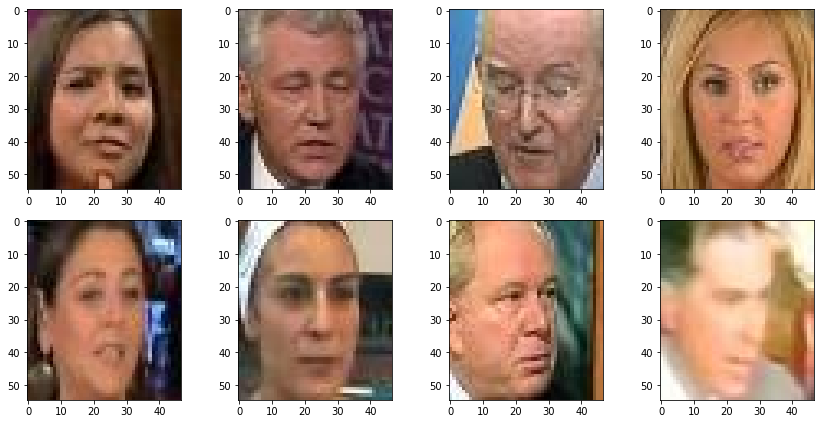

In [12]:
row, col = 2, 4
fig, axes = plt.subplots(row, col, figsize=(12, 6))
axes = axes.flatten()
for i in range(min(len(x_clean), row * col)):
    idx = np.random.randint(1, x_clean.shape[0])
    img, label = x_clean[idx], y_clean[idx]
    axes[i].imshow(img/255)
plt.tight_layout()
plt.show()

In [13]:
# Bad data visualization

In [14]:
x_bd, y_bd = bad_valid_x, bad_valid_y

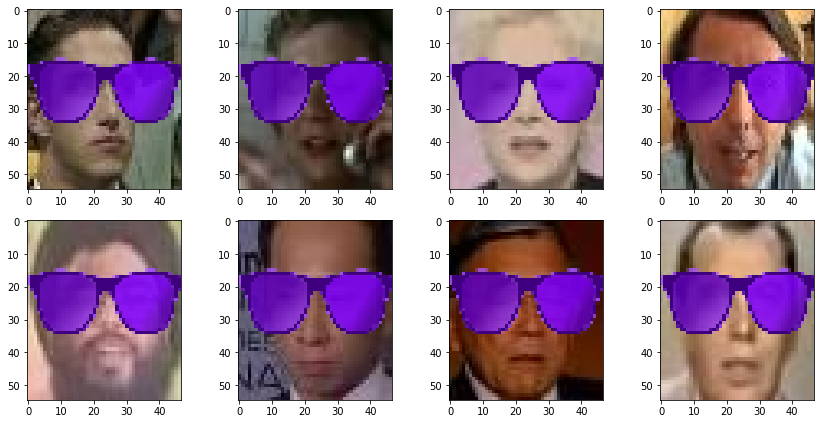

In [15]:
row, col = 2, 4
fig, axes = plt.subplots(row, col, figsize=(12, 6))
axes = axes.flatten()
for i in range(min(len(x_bd), row * col)):
    idx = np.random.randint(1, x_bd.shape[0])
    img, label = x_bd[idx], y_bd[idx]
    axes[i].imshow(img/255)
plt.tight_layout()
plt.show()

In [ ]:
# Model summary

In [16]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [17]:
model_new = keras.models.clone_model(model)
model_new.set_weights(model.get_weights())

In [ ]:
# Findind activations & sorting them in descending order

In [18]:
intermediate_model=keras.models.Model(inputs=model_new.input,outputs=model_new.get_layer('pool_3').output)
intermediate_model_prediction=intermediate_model.predict(x_clean)
activation_array = np.mean(intermediate_model_prediction,axis=(0,1,2))
activation_array_descending = np.argsort(activation_array)[::-1]

361/361 [==============================] - 2s 6ms/step


In [19]:
index = model.layers.index(model.get_layer(name='pool_3')) - 1
weights = model_new.layers[index].get_weights()[0]
bias = model_new.layers[index].get_weights()[1]

In [20]:
model_2_flag = False
model_4_flag = False
model_10_flag = False

In [21]:
accuracy_clean_list = []
accuracy_bd_list = []
for channel in activation_array_descending:
    weights[:,:,:,channel] = 0
    bias[channel] = 0
    model_new.layers[index].set_weights([weights, bias])
    model_new_predict = np.argmax(model_new.predict(x_clean), axis=1)
    accuracy_clean = np.mean(np.equal(model_new_predict, y_clean))
    accuracy_clean_list.append(accuracy_clean)
    model_new_predict_bd = np.argmax(model_new.predict(x_bd), axis=1)
    accuracy_bd = np.mean(np.equal(model_new_predict_bd, y_bd))
    accuracy_bd_list.append(accuracy_bd)
    print("Channel pruned: ", channel)
    print("Clean accuracy: ", accuracy_clean, "bd accuracy: ", accuracy_bd)
    if clean_valid_accuracy - accuracy_clean > 0.02 and not model_2_flag:
        model_new.save('model_2.h5')
        print("Model saved for 2%")
        model_2_flag = True
    if clean_valid_accuracy - accuracy_clean > 0.04 and not model_4_flag:
        model_new.save('model_4.h5')
        print("Model saved for 4%")
        model_4_flag = True
    if clean_valid_accuracy - accuracy_clean > 0.10 and not model_10_flag:
        model_new.save('model_10.h5')
        print("Model saved for 10%")
        model_10_flag = True
    if model_2_flag and model_4_flag and model_10_flag:
        break
    keras.backend.clear_session()

361/361 [==============================] - 3s 7ms/step
Channel pruned:  57
Clean accuracy:  0.9429288992811986 bd accuracy:  1.0
Model saved for 2%
Model saved for 4%


/home/jpr8961/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


361/361 [==============================] - 3s 7ms/step
Channel pruned:  52
Clean accuracy:  0.7414912964406339 bd accuracy:  1.0
Model saved for 10%


In [ ]:
# New model design

In [22]:
class G(keras.Model):
    def __init__(self, B, B_dash):
        super(G, self).__init__()
        self.B = B
        self.B_dash = B_dash
        
    def predict(self, data):
        y = np.argmax(self.B(data), axis = 1)
        y_dash = np.argmax(self.B_dash(data), axis = 1)
        prediction = np.zeros(data.shape[0])
        N = int(np.max(y_clean)) + 1
        mask = y == y_dash
        prediction = np.where(mask, y, N)
        return prediction

In [23]:
clean_test = 'cl/test.h5'
bd_test = 'bd/bd_test.h5'

In [24]:
model_2 = keras.models.load_model('model_2.h5')
model_4 = keras.models.load_model('model_4.h5')
model_10 = keras.models.load_model('model_10.h5')

G_model_2 = G(model, model_2)
G_model_4 = G(model, model_4)
G_model_10 = G(model, model_10)

In [25]:
x_clean_test, y_clean_test = data_loader(clean_test)
x_bd_test, y_bd_test = data_loader(bd_test)

In [26]:
clean_pred_2 = np.argmax(model_2.predict(x_clean_test), axis=1)
clean_accuracy_2 = np.mean(np.equal(clean_pred_2, y_clean_test))
print('Model 2%: Clean test data accuracy:', clean_accuracy_2)

clean_pred_4 = np.argmax(model_4.predict(x_clean_test), axis=1)
clean_accuracy_4 = np.mean(np.equal(clean_pred_4, y_clean_test))
print('Model 4%: Clean test data accuracy:', clean_accuracy_4)

clean_pred_10 = np.argmax(model_10.predict(x_clean_test), axis=1)
clean_accuracy_10 = np.mean(np.equal(clean_pred_10, y_clean_test))
print('Model 10%: Clean test data accuracy:', clean_accuracy_10)

401/401 [==============================] - 3s 8ms/step
Model 2%: Clean test data accuracy: 0.9413094310210445
401/401 [==============================] - 3s 8ms/step
Model 4%: Clean test data accuracy: 0.9413094310210445
401/401 [==============================] - 3s 8ms/step
Model 10%: Clean test data accuracy: 0.7424785658612627


In [49]:
bd_pred_2 = np.argmax(model_2.predict(x_bd_test), axis=1)
bd_accuracy_2 = np.mean(np.equal(bd_pred_2, y_bd_test))
print('Model 2%: Bad test data accuracy:', bd_accuracy_2, ' Success rate: ', bd_accuracy_2*100)

bd_pred_4 = np.argmax(model_4.predict(x_bd_test), axis=1)
bd_accuracy_4 = np.mean(np.equal(bd_pred_4, y_bd_test))
print('Model 4%: Bad test data accuracy:', bd_accuracy_4, ' Success rate: ', bd_accuracy_4*100)

bd_pred_10 = np.argmax(model_10.predict(x_bd_test), axis=1)
bd_accuracy_10 = np.mean(np.equal(bd_pred_10, y_bd_test))
print('Model 10%: Bad test data accuracy:', bd_accuracy_10, ' Success rate: ', bd_accuracy_10*100)

401/401 [==============================] - 3s 7ms/step
Model 2%: Bad test data accuracy: 1.0  Success rate:  100.0
401/401 [==============================] - 3s 7ms/step
Model 4%: Bad test data accuracy: 1.0  Success rate:  100.0
401/401 [==============================] - 3s 7ms/step
Model 10%: Bad test data accuracy: 1.0  Success rate:  100.0


In [28]:
clean_pred_G_2 = G_model_2.predict(x_clean_test)
clean_accuracy_G_2 = np.mean(np.equal(clean_pred_G_2, y_clean_test))
print('Model 2%: Clean test data accuracy:', clean_accuracy_G_2)

clean_pred_G_4 = G_model_4.predict(x_clean_test)
clean_accuracy_G_4 = np.mean(np.equal(clean_pred_G_4, y_clean_test))
print('Model 4%: Clean test data accuracy:', clean_accuracy_G_4)

clean_pred_G_10 = G_model_10.predict(x_clean_test)
clean_accuracy_G_10 = np.mean(np.equal(clean_pred_G_10, y_clean_test))
print('Model 10%: Clean test data accuracy:', clean_accuracy_G_10)

Model 2%: Clean test data accuracy: 0.9395946999220577
Model 4%: Clean test data accuracy: 0.9395946999220577
Model 10%: Clean test data accuracy: 0.7409197194076383


In [50]:
bd_pred_G_2 = G_model_2.predict(x_bd_test)
bd_accuracy_G_2 = np.mean(np.equal(bd_pred_G_2, y_bd_test))
print('Model 2%: Bad test data accuracy:', bd_accuracy_G_2, ' Success rate: ', bd_accuracy_G_2*100)

bd_pred_G_4 = G_model_4.predict(x_bd_test)
bd_accuracy_G_4 = np.mean(np.equal(bd_pred_G_4, y_bd_test))
print('Model 4%: Bad test data accuracy:', bd_accuracy_G_4, ' Success rate: ', bd_accuracy_G_4*100)

bd_pred_G_10 = G_model_10.predict(x_bd_test)
bd_accuracy_G_10 = np.mean(np.equal(bd_pred_G_10, y_bd_test))
print('Model 10%: Bad test data accuracy:', bd_accuracy_G_10, ' Success rate: ', bd_accuracy_G_10*100)

Model 2%: Bad test data accuracy: 1.0  Success rate:  100.0
Model 4%: Bad test data accuracy: 1.0  Success rate:  100.0
Model 10%: Bad test data accuracy: 1.0  Success rate:  100.0


In [51]:
G_model_2.save('G_model_2.h5')
G_model_4.save('G_model_4.h5')
G_model_10.save('G_model_10.h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [43]:
!python3 eval.py cl/test.h5 bd/bd_test.h5 model_2.h5

2023-12-04 19:37:48.301835: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 19:37:48.304612: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:37:48.360190: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:37:48.360788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 19:37:50.800985: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [45]:
!python3 eval.py cl/test.h5 bd/bd_test.h5 model_4.h5

2023-12-04 19:38:35.167757: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 19:38:35.170508: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:38:35.226586: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:38:35.227187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 19:38:37.701463: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [46]:
!python3 eval.py cl/test.h5 bd/bd_test.h5 model_10.h5

2023-12-04 19:38:51.187742: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 19:38:51.190448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:38:51.244965: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-04 19:38:51.245558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 19:38:53.393677: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co